In [1]:
# Loading data

import pandas as pd

# Set paths
DATA_PATH = "../data/"

# Load all CSV files
train = pd.read_csv(DATA_PATH + "train.csv", parse_dates=["date"])
test = pd.read_csv(DATA_PATH + "test.csv", parse_dates=["date"])
stores = pd.read_csv(DATA_PATH + "stores.csv")
oil = pd.read_csv(DATA_PATH + "oil.csv", parse_dates=["date"])
holidays = pd.read_csv(DATA_PATH + "holidays_events.csv", parse_dates=["date"])
transactions = pd.read_csv(DATA_PATH + "transactions.csv", parse_dates=["date"])
sample_submission = pd.read_csv(DATA_PATH + "sample_submission.csv")

# Preview
train.head()


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [2]:
# Checking shapes and info

print("Train:", train.shape)
print("Test:", test.shape)
print("Stores:", stores.shape)
print("Oil:", oil.shape)
print("Holidays:", holidays.shape)
print("Transactions:", transactions.shape)


Train: (3000888, 6)
Test: (28512, 5)
Stores: (54, 5)
Oil: (1218, 2)
Holidays: (350, 6)
Transactions: (83488, 3)


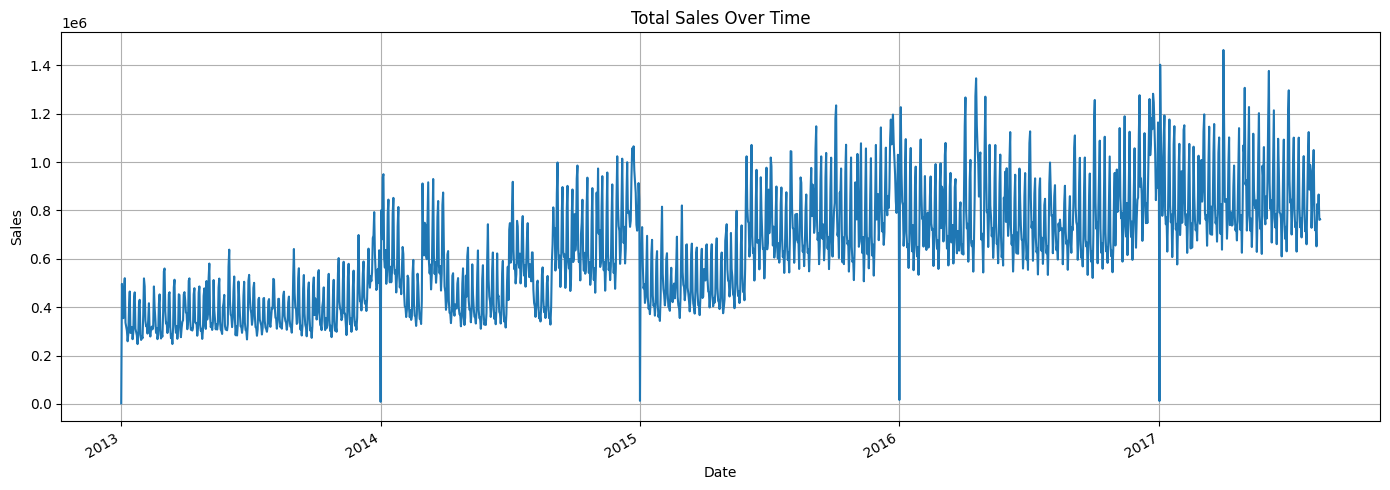

In [3]:
# Visulaizing trends

import matplotlib.pyplot as plt

# Daily total sales
daily_sales = train.groupby("date")["sales"].sum()

plt.figure(figsize=(14,5))
daily_sales.plot()
plt.title("Total Sales Over Time")
plt.ylabel("Sales")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
# Merge store info
train_merged = train.merge(stores, on="store_nbr", how="left")
test_merged = test.merge(stores, on="store_nbr", how="left")

train_merged.head()


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13


In [5]:
# Merge oil prices on date
train_merged = train_merged.merge(oil, on="date", how="left")
test_merged = test_merged.merge(oil, on="date", how="left")

# Check for nulls in oil prices
train_merged["dcoilwtico"].isna().mean()


0.30938242280285033

~31% of oil prices are missing from the training data

In [6]:
# Fill missing oil prices with forward then backward fill
train_merged["dcoilwtico"] = train_merged["dcoilwtico"].ffill().bfill()
test_merged["dcoilwtico"] = test_merged["dcoilwtico"].ffill().bfill()

# Check again to confirm
print("Remaining nulls:", train_merged["dcoilwtico"].isna().sum())


Remaining nulls: 0


In [7]:
# Step 1: Filter and create a binary flag
holidays_filtered = holidays[holidays["transferred"] == False].copy()
holidays_filtered["is_holiday"] = 1

# Step 2: Create clean date-holiday DataFrame
holiday_flags = holidays_filtered[["date", "is_holiday"]].drop_duplicates()

# Step 3 (safe merge): Drop 'is_holiday' if it already exists
for df in [train_merged, test_merged]:
    if "is_holiday" in df.columns:
        df.drop(columns=["is_holiday"], inplace=True)

# Now merge without risk of column conflict
train_merged = train_merged.merge(holiday_flags, on="date", how="left")
test_merged = test_merged.merge(holiday_flags, on="date", how="left")

# Step 4: Fill NaNs with 0 (non-holiday)
train_merged["is_holiday"] = train_merged["is_holiday"].fillna(0).astype(int)
test_merged["is_holiday"] = test_merged["is_holiday"].fillna(0).astype(int)

# Drop duplicate versions of is_holiday if they exist
for col in ["is_holiday_x", "is_holiday_y"]:
    if col in train_merged.columns:
        train_merged.drop(columns=[col], inplace=True)
    if col in test_merged.columns:
        test_merged.drop(columns=[col], inplace=True)

# Confirm clean structure
train_merged[["date", "is_holiday"]].drop_duplicates().head()

train_merged.head()



,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,is_holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,93.14,1
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,93.14,1
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,93.14,1
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,93.14,1
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,93.14,1


In [8]:
# Merge transactions into train/test
train_merged = train_merged.merge(transactions, on=["store_nbr", "date"], how="left")
test_merged = test_merged.merge(transactions, on=["store_nbr", "date"], how="left")

# Fill missing values
train_merged["transactions"] = train_merged["transactions"].ffill().bfill()
test_merged["transactions"] = test_merged["transactions"].ffill().bfill()
test_merged["transactions"] = test_merged["transactions"].fillna(0)

# Confirm it's clean
print("Train nulls:", train_merged["transactions"].isna().sum())
print("Test nulls:", test_merged["transactions"].isna().sum())


Train nulls: 0
Test nulls: 0


In [9]:
print(train_merged.columns.tolist())


['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city', 'state', 'type', 'cluster', 'dcoilwtico', 'is_holiday', 'transactions']


In [10]:
# Save to CSV
train_merged.to_csv("../data/train_cleaned.csv", index=False)
test_merged.to_csv("../data/test_cleaned.csv", index=False)


In [11]:
# Convert date column if needed
train_merged["date"] = pd.to_datetime(train_merged["date"])
test_merged["date"] = pd.to_datetime(test_merged["date"])

# Extract date parts
for df in [train_merged, test_merged]:
    df["day"] = df["date"].dt.day
    df["month"] = df["date"].dt.month
    df["year"] = df["date"].dt.year
    df["day_of_week"] = df["date"].dt.dayofweek
    df["week_of_year"] = df["date"].dt.isocalendar().week.astype(int)


In [12]:
# Create lag features for sales
def add_lag_features(df, lags=[1, 7, 14]):
    for lag in lags:
        df[f"lag_{lag}"] = (
            df.groupby(["store_nbr", "family"])["sales"]
              .shift(lag)
        )
    return df

# Apply to training data
train_merged = add_lag_features(train_merged)


In [13]:
# Create rolling mean features for sales
def add_rolling_means(df, windows=[7, 14]):
    for window in windows:
        df[f"rolling_mean_{window}"] = (
            df.groupby(["store_nbr", "family"])["sales"]
              .transform(lambda x: x.shift(1).rolling(window=window).mean())
        )
    return df

# Apply to training data
train_merged = add_rolling_means(train_merged)


In [14]:
# Drop rows with NaNs from lag/rolling features (they occur at the start of time series)
train_model_ready = train_merged.dropna().copy()

# Save for modeling
train_model_ready.to_csv("../data/train_features.csv", index=False)


In [15]:
# loading dataset for modelling

import pandas as pd

df = pd.read_csv("../data/train_features.csv")

# Optional: quick sanity check
df[["date", "store_nbr", "family", "sales"]].head()


,date,store_nbr,family,sales
0,2013-01-15,1,AUTOMOTIVE,1.0
1,2013-01-15,1,BABY CARE,0.0
2,2013-01-15,1,BEAUTY,0.0
3,2013-01-15,1,BEVERAGES,1149.0
4,2013-01-15,1,BOOKS,0.0


In [16]:
# Preparing Data for modelling

from sklearn.model_selection import train_test_split

# Define features and target, One-hot encode categorical features
X_full = pd.get_dummies(df.drop(columns=["sales", "date", "id"]), drop_first=True)

# Split target
y = df["sales"]

# Train-test split, Split into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(
    X_full, y, test_size=0.2, random_state=42
)



In [17]:
# Training XGBoost

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Instantiate and train model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Predict on validation set
y_pred = model.predict(X_valid)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
print(f"RMSE on validation set: {rmse:.2f}")


RMSE on validation set: 199.91


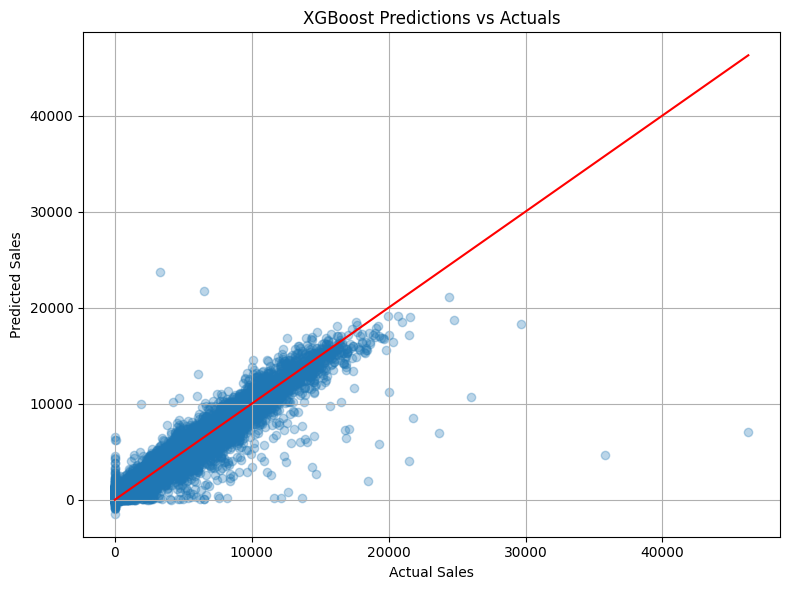

In [18]:
# Visualizing & Interpreting
# Plotting Predicted vs Actual Sales

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_valid, y_pred, alpha=0.3)
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], color='red')
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("XGBoost Predictions vs Actuals")
plt.grid(True)
plt.tight_layout()
plt.show()


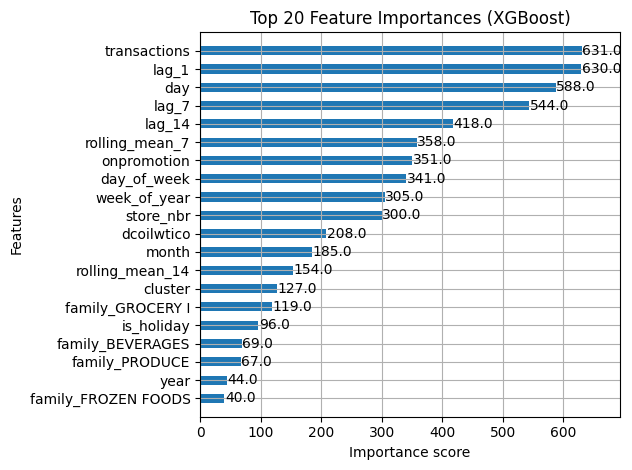

In [19]:
# Feature Importance

import matplotlib.pyplot as plt
import xgboost as xgb

# Plot top 20 features by importance
xgb.plot_importance(model, max_num_features=20, height=0.5, grid=True)
plt.title("Top 20 Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()


In [21]:
# Hyperparameter Tuning with GridSearchCV
# Trying different combinations of XGBoost parameters to improve validation RMSE

from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

X_sub = X_train.sample(10000, random_state=42)
y_sub = y_train.loc[X_sub.index]

grid = GridSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_grid={
        "n_estimators": [100, 200],
        "max_depth": [3, 6],
        "learning_rate": [0.1]
    },
    cv=2,
    scoring="neg_root_mean_squared_error",
    verbose=1,
    n_jobs=1
)

grid.fit(X_sub, y_sub)


Fitting 2 folds for each of 4 candidates, totalling 8 fits


GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=1,
             param_grid={'learning_rate': [0.1], 'max_depth': [3, 6],
                         'n_estimators': [100, 200]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [22]:
# Final Model Training with Best Parameters
# Re-train the best XGBoost model on the full training data (after tuning with GridSearchCV)

from xgboost import XGBRegressor

# Initialize model using best parameters from GridSearchCV
best_model = XGBRegressor(
    learning_rate=0.1,    # how fast the model learns
    max_depth=3,          # limits tree complexity to prevent overfitting
    n_estimators=200,     # number of boosting rounds (trees)
    random_state=42       # ensures reproducibility
)

# Fit the model on full training data (X_train)
best_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [28]:
# Select features for modeling
# Drop columns not needed for training (non-numeric or identifiers)

# Step 1: Drop unnecessary columns before encoding
cols_to_drop = ["id", "date", "sales"]
data = train_merged.drop(columns=cols_to_drop, errors='ignore')

# Step 2: One-hot encode categorical features
# This ensures all columns are aligned for train and validation
data_encoded = pd.get_dummies(data, drop_first=True)

# Step 3: Define features (X) and target (y)
X = data_encoded
y = train_merged["sales"]

# Step 4: Split into train and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ✅ Now safe to use: model.predict(X_val)


In [29]:
# Model Evaluation on Validation Set
# Use RMSE to assess how well the model performs on unseen data

from sklearn.metrics import mean_squared_error
import numpy as np

# Predict on validation set
y_pred = best_model.predict(X_val)

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Validation RMSE: {rmse:.2f}")


Validation RMSE: 478.85


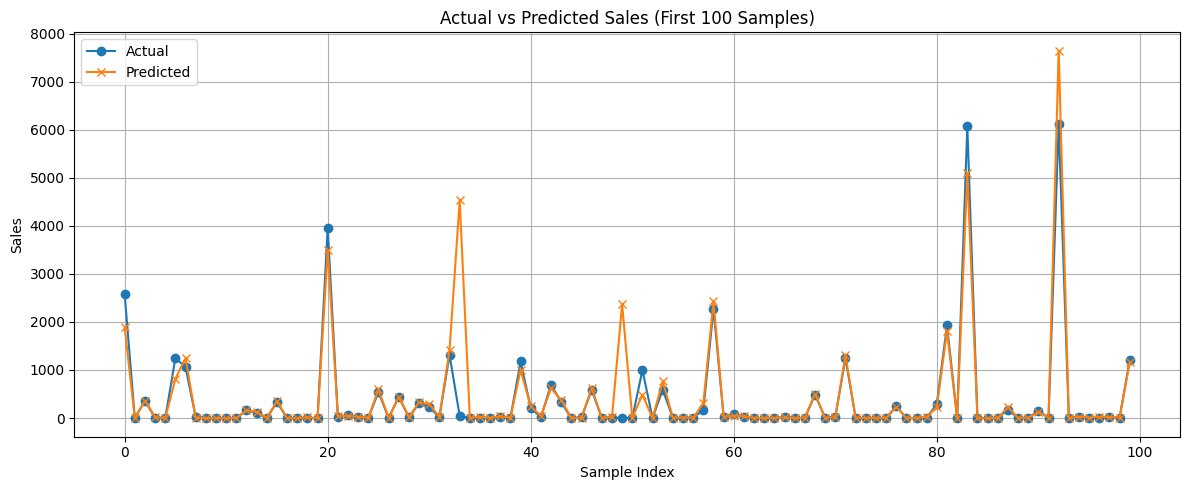

In [30]:
# Step 1: Import plotting library
import matplotlib.pyplot as plt

# Step 2: Create a new figure with specified size
plt.figure(figsize=(12, 5))

# Step 3: Plot the actual sales values (first 100 for visibility)
plt.plot(y_val.values[:100], label="Actual", marker='o')  # ground truth

# Step 4: Plot the predicted sales values (first 100 to match)
plt.plot(y_pred[:100], label="Predicted", marker='x')  # model output

# Step 5: Add title and axis labels
plt.title("Actual vs Predicted Sales (First 100 Samples)")
plt.xlabel("Sample Index")   # x-axis: index of sample
plt.ylabel("Sales")          # y-axis: sales value

# Step 6: Add legend and grid for clarity
plt.legend()
plt.grid(True)

# Step 7: Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [31]:
# Save the trained model as a .pkl file
import joblib

joblib.dump(best_model, "xgb_favorita_model.pkl")

print("✅ Model saved as 'xgb_favorita_model.pkl'")


✅ Model saved as 'xgb_favorita_model.pkl'


In [32]:
import shap


In [33]:
# Create SHAP explainer for your XGBoost model
explainer = shap.Explainer(best_model)

# Calculate SHAP values for the validation set
shap_values = explainer(X_val)


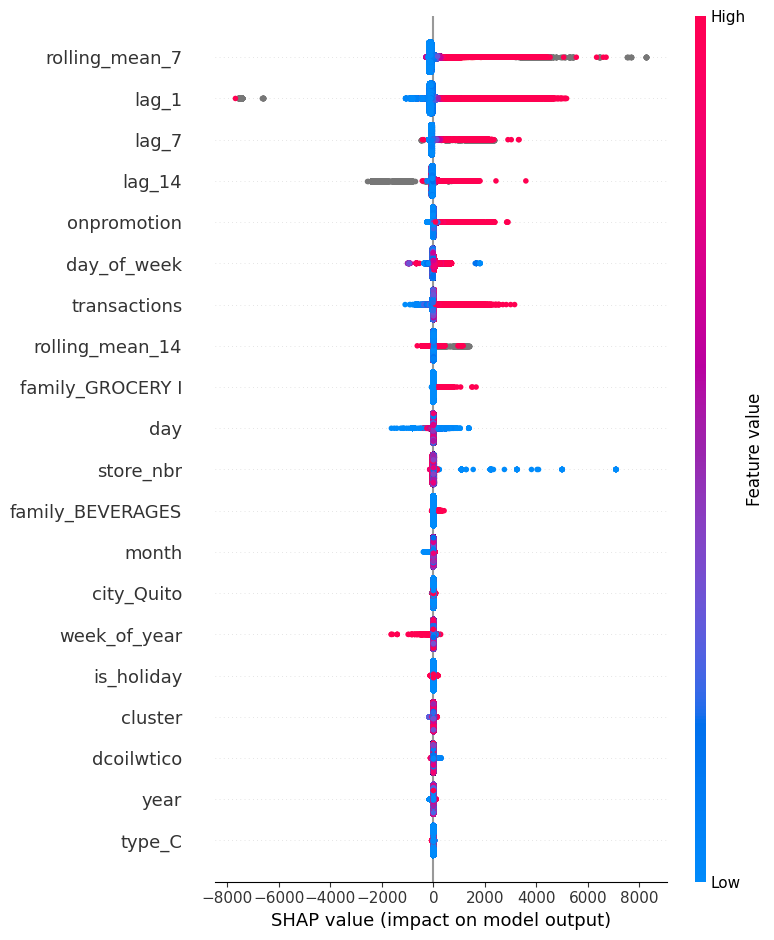

In [34]:
# Plot SHAP summary (global impact of each feature)
shap.summary_plot(shap_values, X_val)


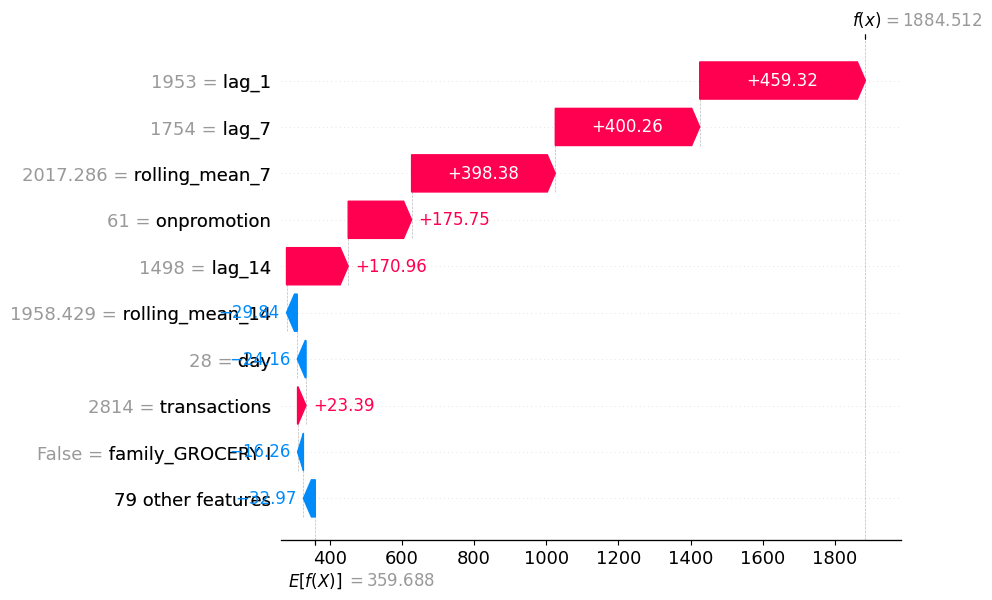

In [35]:
# Pick a sample row from X_val
sample = X_val.iloc[0:1]

# Plot how features contribute to that specific prediction
shap.plots.waterfall(shap_values[0])
